# FNO3D for the 2D Navier-Stokes

> [Original script](../scripts/fourier_3d.py) by Zongyi Li

Treated the time dimension as the third dimension to do convolution, that way we can map whatever spatiotemporal data block to other spatiotemporal data block, i.e. 

$$
\mathcal{L}: w(x,t\in[0, T]) \mapsto w(x, t\in[T, T+\Delta T]).
$$

<!-- > The single input data has the shape: (x,y,T_in); the output has the shape (x, y, T); 
> we treat T_in as the channel dimension and repeat the input in T's dimension, (x, y, T_in) -> (x, y, T, T_in) = (x, y, t, channel). Then we do FFT on x,y,t. We do FFT in T's dimension instead of T_in's dimension, because in many cases T_in=1 (we only have the initial condition).

> The prepared input now has the shape (x, y, T, T_in) = (x, y, t, channel), and it's constant in t-dimension, -->



In [ ]:
# load packages

import torch
import matplotlib.pyplot as plt

import sys
import wandb
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.training import AdamW
# from neuralop.data.datasets import load_navier_stokes_pt
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from pathlib import Path

device = 'cpu'

: 

In [9]:
# prepare and load custom dataset
# see NS 2d dataset from https://github.com/lyyc199586/OFormer/tree/main
# according to doc of PTDataset, the dataset should have:
# train_db: torch.utils.data.Dataset of training examples
# test_db:  ""                       of test examples
# data_processor: neuralop.data.transforms.DataProcessor to process data examples
#     optional, default is None

import numpy as np
from typing import Union, List
from torch.utils.data import DataLoader
from neuralop.data.datasets.tensor_dataset import TensorDataset
from neuralop.data.transforms.normalizers import UnitGaussianNormalizer
from neuralop.data.transforms.data_processors import DefaultDataProcessor
from einops import rearrange

class NSData:
    def __init__(self,
                 root_dir: Union[Path, str],
                 n_train: int,
                 n_tests: List[int],
                 batch_size: int,
                 test_batch_sizes: List[int],
                 train_resolution: int,
                 test_resolutions: int=[16,32],
                 encode_input: bool=False,
                 encode_output: bool=True,
                 encoding="channel-wise",
                 channel_dim=1):
        if isinstance(root_dir, str):
            root_dir = Path(root_dir)
            
        self.root_dir = root_dir
        
        self.batch_size = batch_size
        self.test_resolutions = test_resolutions
        self.test_batch_sizes = test_batch_sizes
        
        #### load data
        data = np.load(root_dir)
        data = rearrange(data, 't x y n -> n 1 x y t') # rearrange to (num, channel=1, x, y, time)
        data = torch.from_numpy(data).float()
        
        #### split train data and test data list from a single dataset
        train_data = data[:n_train]
        print(
            f"Loading train db ({train_data.shape}) for with {n_train} samples "
        )
        test_data_list = []
        for n_test in n_tests:
            test_data_list.append(data[n_train:n_train+n_test])
            n_train += n_test
        
        #### Train data
        x_train = train_data[...,:10]
        y_train = train_data[...,10:]
        
        if encode_input:
            if encoding == "channel-wise":
                reduce_dims = list(range(x_train.ndim))
                # preserve mean for each channel
                reduce_dims.pop(channel_dim)
            elif encoding == "pixel-wise":
                reduce_dims = [0]

            input_encoder = UnitGaussianNormalizer(dim=reduce_dims)
            input_encoder.fit(x_train)
        else:
            input_encoder = None

        if encode_output:
            if encoding == "channel-wise":
                reduce_dims = list(range(y_train.ndim))
                # preserve mean for each channel
                reduce_dims.pop(channel_dim)
            elif encoding == "pixel-wise":
                reduce_dims = [0]

            output_encoder = UnitGaussianNormalizer(dim=reduce_dims)
            output_encoder.fit(y_train)
        else:
            output_encoder = None
            
        # Save train dataset
        self._train_db = TensorDataset(
            x_train,
            y_train,
        )
        
        # create DataProcessor
        self._data_processor = DefaultDataProcessor(in_normalizer=input_encoder,
                                                   out_normalizer=output_encoder)
        
        ### Test data
        self._test_dbs = {}
        for (res, n_test, test_data) in zip(test_resolutions, n_tests, test_data_list):
            print(
                f"Loading test db for resolution {res} ({test_data.shape}) with {n_test} samples "
            )
            x_test = test_data[...,:10]
            y_test = test_data[...,10:]
            
            test_db = TensorDataset(
                x_test,
                y_test,
            )
            self._test_dbs[res] = test_db
            
        del data

    @property
    def data_processor(self):
        return self._data_processor
    
    @property
    def train_db(self):
        return self._train_db
    
    @property
    def test_dbs(self):
        return self._test_dbs

def load_ns2d_npy(
    root_dir: Union[Path, str],
    n_train: int,
    n_tests: List[int],
    batch_size: int,
    test_batch_sizes: List[int],
    train_resolution: int,
    test_resolutions: int=[16,32],
    encode_input: bool=False,
    encode_output: bool=True,
    encoding="channel-wise",
    channel_dim=1
):
    dataset = NSData(
        root_dir=root_dir,
        n_train=n_train,
        n_tests=n_tests,
        batch_size=batch_size,
        test_batch_sizes=test_batch_sizes,
        train_resolution=train_resolution,
        test_resolutions=test_resolutions,
        encode_input=encode_input,
        encode_output=encode_output,
        encoding=encoding,
        channel_dim=channel_dim
    )
    
    # return dataloaders for backwards compat
    train_loader = DataLoader(dataset.train_db,
                              batch_size=batch_size,
                              num_workers=24, # cpu nums
                              pin_memory=True,
                              persistent_workers=False,)
    
    test_loaders = {}
    for res,test_bsize in zip(test_resolutions, test_batch_sizes):
        test_loaders[res] = DataLoader(dataset.test_dbs[res],
                                       batch_size=test_bsize,
                                       shuffle=False,
                                       num_workers=24, # cpu nums
                                       pin_memory=True,
                                       persistent_workers=False,)
    
    return train_loader, test_loaders, dataset.data_processor

# load data
data_dir='/home/yliu664/scr4_sghosh20/yang/no_playground/neuralop-playground/data/navier_stokes/fno_ns_Re1000_N1200_T20.npy'
train_loader, test_loaders, data_processor = load_ns2d_npy(
    root_dir=data_dir,
    n_train=1000,
    n_tests=[200],
    batch_size=10,
    test_batch_sizes=[10],
    train_resolution=64,
    test_resolutions=[64],
    encode_input=False,
    encode_output=False,
    encoding="channel-wise",
    channel_dim=1,
)
data_processor = data_processor.to(device)


Loading train db (torch.Size([1000, 1, 64, 64, 20])) for with 1000 samples 
Loading test db for resolution 64 (torch.Size([200, 1, 64, 64, 20])) with 200 samples 


Training sample 49 - x shape:torch.Size([1, 64, 64, 10])
Training sample 49 - y shape:torch.Size([1, 64, 64, 10])
Test sample 49 - x shape:torch.Size([1, 64, 64, 10])
Test sample 49 - y shape:torch.Size([1, 64, 64, 10])


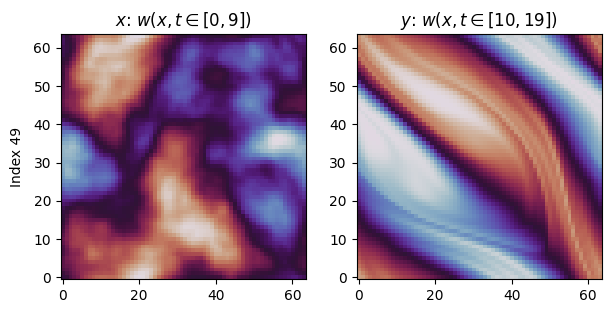

In [10]:
%matplotlib inline
# check data
train_dataset = train_loader.dataset # [id_data, 'x'/'y', [channels,width,height]]
test_dataset = test_loaders[64].dataset

index = 49

print(f"Training sample {index} - x shape:{train_dataset[index]['x'].shape}")
print(f"Training sample {index} - y shape:{train_dataset[index]['y'].shape}")
print(f"Test sample {index} - x shape:{test_dataset[index]['x'].shape}")
print(f"Test sample {index} - y shape:{test_dataset[index]['y'].shape}")

# plot to have a look
data = train_dataset[index]
x = data['x']
y = data['y']
t = 0

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(2, 2, 1)
ax.annotate(f"Index {index}", xy=(-0.15, 0.5), 
             xycoords="axes fraction",
             ha="right", va="center", rotation=90)
ax.imshow(x[0,:,:,t], origin='lower', cmap='twilight')
ax.set_title('$x$: $w(x, t\in[0, 9])$')
ax = fig.add_subplot(2, 2, 2)
ax.imshow(y[0,:,:,t], origin='lower', cmap='twilight')
ax.set_title('$y$: $w(x, t\in[10, 19])$')
plt.show()

In [14]:
# config model
model = FNO(
    n_modes=(8,8,10),
    in_channels=1,
    out_channels=1,
    hidden_channels=32,
    n_layers=4,
    projection_channel_ratio=2,
    positional_embedding = 'grid'
)
model = model.to(device)
data_processor = data_processor.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 3158945 parameters.


In [15]:
epochs=500
learning_rate=1e-3
scheduler_step=100
scheduler_gamma=0.5

# training setup
optimizer = AdamW(
    model.parameters(),
    lr=learning_rate, # learning rate
    weight_decay=1e-4
)

# use StepLR scheduler
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=scheduler_step, gamma=scheduler_gamma
)

# losses setup
l2loss = LpLoss(d=2, p=2, measure=[1,1,10])
h1loss = H1Loss(d=2, measure=[1,1,10])

train_loss = h1loss # use H1 loss
eval_losses = {'h1': h1loss, 'l2':l2loss}

print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()



### MODEL ###
 FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([32, 32, 8, 8, 6]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
          (1): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(4, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64

In [16]:
# %%capture out
trainer = Trainer(
    model=model,
    n_epochs=epochs,
    data_processor=data_processor,
    device=device,
    mixed_precision=False,
    eval_interval=5,
    log_output=False,
    use_distributed=False,
    verbose=True,
    wandb_log = False
)

# train
trainer.train(
    train_loader=train_loader,
    test_loaders=test_loaders,
    optimizer=optimizer,
    scheduler=scheduler,
    regularizer=False,
    training_loss=train_loss,
    eval_losses=eval_losses,
    save_every=10,
    save_dir="./ckpt/fno3d/"
)

Training on 1000 samples
Testing on [200] samples         on resolutions [64].
Raw outputs of shape torch.Size([10, 1, 64, 64, 10])
[0] time=85.97, avg_loss=57.0274, train_err=570.2741
Eval: 64_h1=52.5996, 64_l2=29.2907
[Rank 0]: saved training state to ./ckpt/fno3d/
[5] time=89.22, avg_loss=41.8726, train_err=418.7257
Eval: 64_h1=42.7575, 64_l2=20.2371
[10] time=88.84, avg_loss=37.7614, train_err=377.6143
Eval: 64_h1=40.8082, 64_l2=18.7197
[Rank 0]: saved training state to ./ckpt/fno3d/
[15] time=88.97, avg_loss=34.4980, train_err=344.9795
Eval: 64_h1=39.0240, 64_l2=18.1478
[20] time=91.44, avg_loss=34.0416, train_err=340.4162
Eval: 64_h1=38.2342, 64_l2=17.4987
[Rank 0]: saved training state to ./ckpt/fno3d/
[25] time=89.82, avg_loss=33.6095, train_err=336.0952
Eval: 64_h1=38.3564, 64_l2=17.4260
[30] time=88.59, avg_loss=31.1051, train_err=311.0506
Eval: 64_h1=36.9407, 64_l2=16.7766
[Rank 0]: saved training state to ./ckpt/fno3d/
[35] time=87.78, avg_loss=31.0729, train_err=310.7295
E

KeyboardInterrupt: 

In [17]:
# save model
model.save_checkpoint("./model", save_name='fno3d')

In [7]:
# reload model
model_reload = FNO.from_checkpoint('./model', save_name="fno3d")

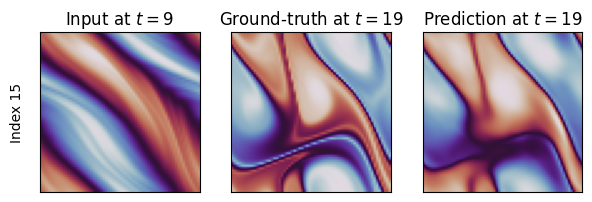

In [19]:
# visualization

def pred_plot(x, y, pred, t, sample_id, axes, cmap='viridis'):
    # input x at t
    ax = axes[0]
    ax.clear()
    ax.imshow(x[0,:,:,t], origin='lower', cmap=cmap)
    ax.annotate(f"Index {sample_id}", xy=(-0.1, 0.5), 
                 xycoords="axes fraction",
                 ha="right", va="center", rotation=90)
    ax.set_title(f'Input at $t={t}$')
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    
    # input y at t+10
    ax = axes[1]
    ax.clear()
    ax.imshow(y[0,:,:,t], origin='lower', cmap=cmap)
    ax.set_title(f'Ground-truth at $t={t+10}$')
    ax.set_xticks([], [])
    ax.set_yticks([], [])

    # prediction at t+10
    ax = axes[2]
    ax.clear()
    ax.imshow(pred[:,:,t], origin='lower', cmap=cmap)
    ax.set_title(f'Prediction at $t={t+10}$')
    ax.set_xticks([], [])
    ax.set_yticks([], [])

    return axes

#### load model
model_use = model 
# model_use = model_reload

test_samples = test_loaders[64].dataset
sample_id = 15

data = test_samples[sample_id]
data = data_processor.preprocess(data, batched=False)

x = data['x']
y = data['y']
out = model_use(x.unsqueeze(0)).squeeze().detach().numpy()
t = 9 # time step

#### plot
fig, axes = plt.subplots(1, 3, figsize=(7, 2.5))
pred_plot(x, y, out, t, sample_id, axes, cmap='twilight')
plt.show()

save to ./navier_stokes/media/ns_fno3d_id50.gif


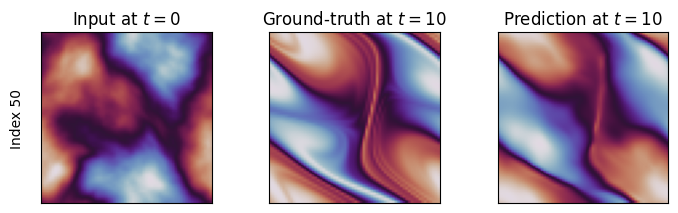

In [23]:
from matplotlib.animation import FuncAnimation

# animation over t in [0, 9]
def pred_anim(model, data, sample_id, save_path=None, fps=2):
    data = test_samples[sample_id]
    data = data_processor.preprocess(data, batched=False)

    x = data['x']
    y = data['y']
    pred = model(x.unsqueeze(0)).squeeze().detach().numpy()
    
    fig, axes = plt.subplots(1, 3, figsize=(7, 2.5))
    
    def update(t):
        pred_plot(x, y, pred, t, sample_id, axes, cmap='twilight')
        return axes
    
    anim = FuncAnimation(fig, update, frames=10, blit=False, repeat=False)
    plt.tight_layout()
    
    if save_path:
        anim.save(save_path, fps=fps)
        print(f"save to {save_path}")
    else:
        plt.show()
    

model_use = model

test_samples = test_loaders[64].dataset
sample_id = 50

save_path = f'./navier_stokes/media/ns_fno3d_id{sample_id}.gif'
pred_anim(model_use, test_samples, sample_id, save_path=save_path, fps=2)

